In [4]:
%%HTML
<!-- Make fonts readable at 1024x768 -->
<style>
.rendered_html { font-size:1.0em; }
.container {width: 100%;}
</style>

In [3]:
import numpy as np
import scipy.signal
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib import animation, patches
from IPython.display import display, Audio, HTML
import soundfile as sf
from style import *

### Bibliografía

1. Weifeng Liu, José Príncipe, Simon Haykin, "Kernel adaptive filtering", *Wiley*
1. Christopher M. Bishop, "Pattern Recognition and Machine Learning", *Springer*, **Capítulo 6**

***
# Filtros adaptivos no-lineales 
***
- Los filtros lineales son sencillos (baja capacidad)
- Hasta ahora hemos asumido que la salida y la entrada se relacionan linealmente
$$
y_n = \langle \textbf{w}, \textbf{u}_n \rangle = \textbf{w}^T \textbf{u}_n = \sum_{k=0}^L w_{k} u_{nk}
$$
- Si esto no se cumple el desempeño del filtro sería subóptimo

In [ ]:
from numpy.lib.stride_tricks import as_strided
fig, ax = plt.subplots(1, figsize=(9, 4))
N = 1000;  L = 50
u = np.linspace(0, 10, num=N)
U = as_strided(u, [len(u)-L , L], strides=[u.strides[0], u.strides[0]])
d = np.cos(2*np.pi*u) + 0.1*u
Ruu = np.dot(U[:, :L].T, U[:, :L])
Rud = np.dot(U[:, :L].T, d[L:, np.newaxis])
h = np.linalg.solve(Ruu, Rud)[:, 0]
ax.plot(u, d, lw=4, alpha=0.7, label='true')
ax.plot(u[L:], np.dot(U, h), lw=4, alpha=0.7, label='estimated'); plt.legend();

- Para solucionar esto necesitamos un modelo que no esté limitado a relaciones lineales
$$
y_n = f_\Omega (\textbf{u}_n)
$$
- Dos maneras de lograr esto 
    - Filtros no-lineales de topología fija: Perceptrón multicapa
    - Método no-paramétrico: **Kernels**

***

## Kernels


- Los filtros basados en kernels operan en un espacio de hilbert con kernel reproductor (RKHS)
- **Espacio de Hilbert:** Espacio infinito de funciones con producto interno (producto punto)
$$
\langle f, g \rangle = \int_{-\infty}^\infty f(x) g(x) dx < \infty
$$
donde $f, g \in H$ son funciones de $\mathbb{R}^N \to \mathbb{R}$s donde $x\in \mathbb{R}^N$
- **Propiedad reproductora:** Existe un elemento de $H$ llamado $\varphi(x)$ tal que
$$
f(x) = \langle f, \varphi(x)  \rangle \quad \forall f \in H
$$
y entonces
$$
\kappa(x, y) = \langle \varphi(x), \varphi(y)  \rangle
$$
se conoce como el **kernel reproductor** de $H$ a $\kappa(x, y): \mathbb{R}^N \times \mathbb{R}^N \to \mathbb{R}$ que es una función simétrica y semidefinido positiva

Esta última igualdad se conoce como **truco del kernel**

***
Usando el truco del kernel podemos convertir un algoritmo lineal a no-lineal reeplazando un producto escalar por un kernel

***

## Kernels y transformaciones no lineales

- Un kernel induce una transformación no lineal en la entrada
- Por ejemplo consideremos el kernel polinomial de segundo grado y asumamos datos de entrada bidimensionales
$$
\begin{align}
\kappa(x, y) &= \langle x, y \rangle^2 \nonumber \\
&= (x_1 y_1)^2 + 2 x_1 y_1 x_2 y_2 + (x_2 y_2)^2 \nonumber \\
&= \Bigg \langle \begin{pmatrix} x_1^2 \\ \sqrt{2} x_1 x_2 \\ x_2^2 \end{pmatrix} \begin{pmatrix} y_1^2 \\ \sqrt{2} y_1 y_2 \\ y_2^2 \end{pmatrix} \Bigg \rangle \nonumber
\end{align}
$$
- Se induce una transformación no lineal a un espacio de tres dimensiones


<IPython.core.display.Javascript object>


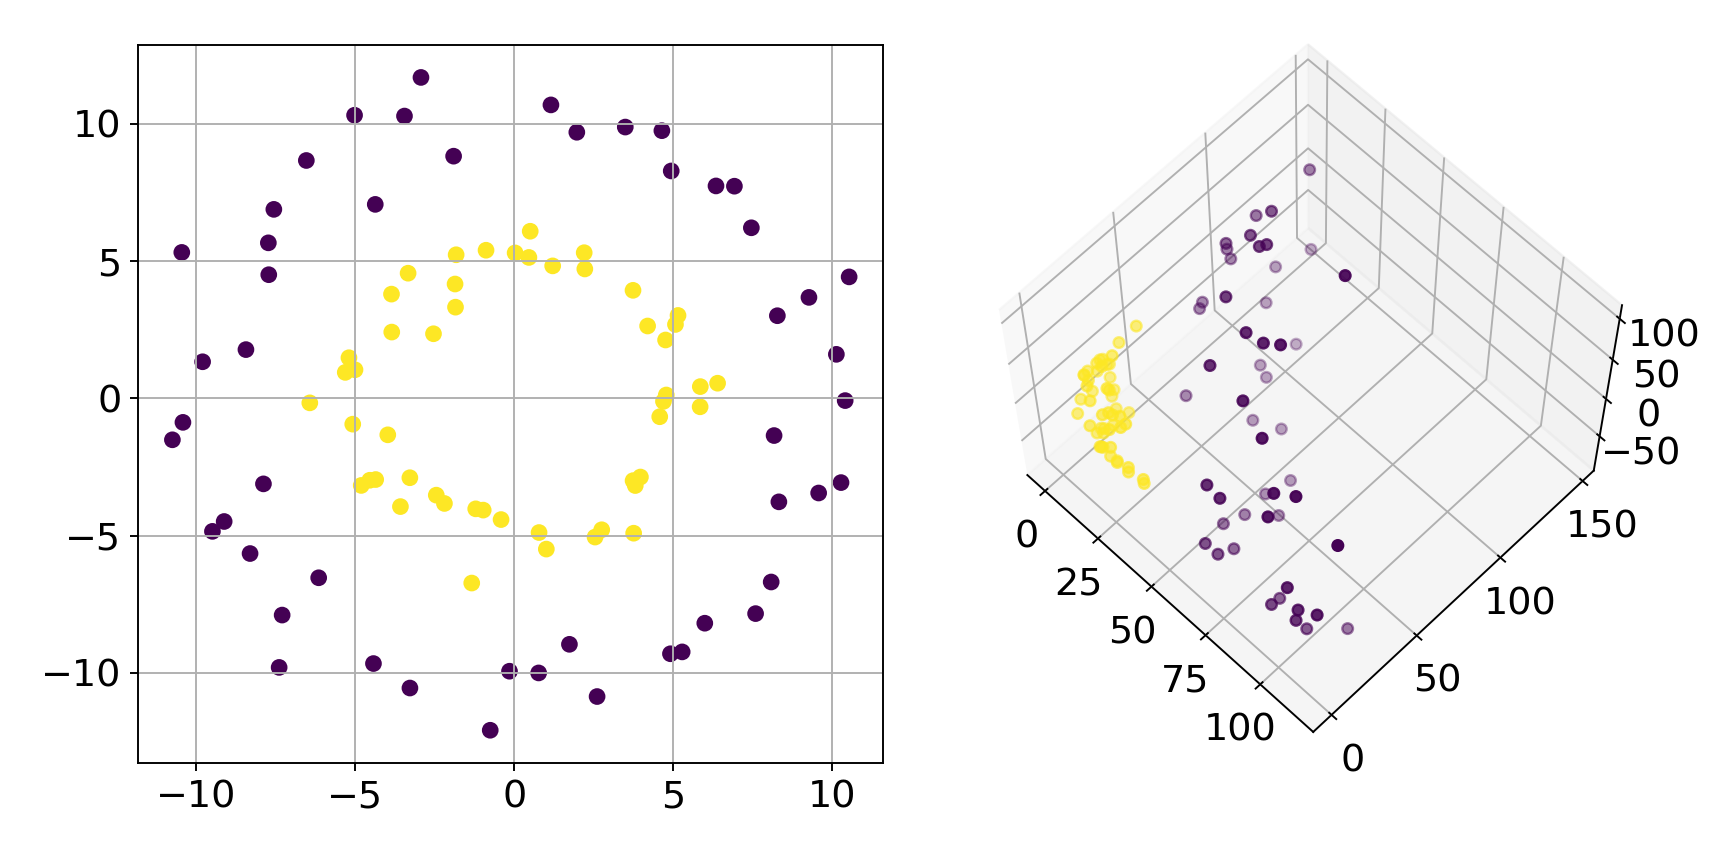

In [5]:
from mpl_toolkits import mplot3d
from sklearn.datasets import make_circles

X, Y = make_circles(n_samples=100, noise=0.08, factor=0.5); X = 10*X
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:, 0], X[:, 1], c=Y)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(X[:, 0]**2, X[:, 1]**2, np.sqrt(2)*X[:,0]*X[:,1], c=Y);

- Consideremos ahora el kernel Gaussiano o RBF para datos N-dimensionales
$$
\begin{align}
\kappa(x, y) &= e^{-\gamma \|x-y\|^2} \nonumber \\
&= e^{-\gamma \|x\|^2} e^{-\gamma \|y\|^2} e^{2\gamma \langle x, y \rangle} \nonumber \\
&= e^{-\gamma \|x\|^2} e^{-\gamma \|y\|^2} \sum_{k=0}^\infty \frac{1}{k!} (2\gamma \langle x, y \rangle)^k \nonumber \\
&= \sum_{k=0}^\infty \Bigg \langle \sqrt{2} \gamma \frac{x}{\sqrt[{2k}]{k!}} e^{-\gamma k^{-1} \|x\|^2}  , \sqrt{2} \gamma \frac{y}{\sqrt[{2k}]{k!}} e^{-\gamma k^{-1} \|y\|^2}  \Bigg \rangle^k \nonumber 
\end{align}
$$
- Se induce una transformación no lineal a un espacio infinito dimensional!
- El kernel Gaussiano crea un RKHS con [capacidad de aproximación universal](jmlr.csail.mit.edu/papers/volume7/micchelli06a/micchelli06a.pdf)
- El parámetro $\gamma = \frac{1}{2\sigma^2}$ se escoge validación cruzada (k-fold si hay pocos datos) 

## Otros kernel válidos

- Kernel polinomial inhomogeneo: $(\langle x, y \rangle +1)^d$
- Kernel Cauchy: $\frac{1}{1 + \gamma \|x-y\|^2}$
- Kernel periódico: $e^{-2 \sin^2(\pi |x-y|/P)/\sigma^2}$
- [Muchos kernels](http://crsouza.com/2010/03/17/kernel-functions-for-machine-learning-applications/)


Construcción de kernels: [The kernel cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/)

***
# Kernel Least Mean Square (KLMS)

***
Recordemos, en el algoritmo LMS teniamos un filtro lineal
$$
y_n = \langle \textbf{w} , \textbf{u}_n  \rangle
$$
y minimizamos el error cuadrático instantaneo (SGD)
$$
e_n^2 = (d_n - y_n)^2
$$
lo que resultaba en
$$
\begin{align}
\textbf{w}_{n+1} &= \textbf{w}_{n} + 2 \mu e_n \textbf{u}_{n}\nonumber \\
&= \textbf{w}_{n} + 2 \mu (d_n -  \textbf{w}_{n}^T \textbf{u}_{n}) \textbf{u}_{n}, \nonumber 
\end{align}
$$
***
Asumamos que
- Transformamos los datos usando $\varphi(\cdot)$, una transformacion no lineal
- Nuestro filtro es lineal en el espacio transformado
$$
y_n = \langle \Omega , \varphi(\textbf{u}_n)  \rangle
$$
- Los parámetros iniciales son nulos $\Omega_0 = 0$

Luego podemos actualizar los parámetros de nuestro filtro
$$
\begin{align}
\Omega_{n+1} &= \Omega_{n} + 2 \mu e_n \varphi(\textbf{u}_n) \nonumber \\
&= 2\mu \sum_{k=0}^n e_k \varphi(\textbf{u}_k) \nonumber
\end{align}
$$
por lo que nuestro filtro no lineal 

$$
\begin{align}
f_\Omega(\textbf{u}_{n+1}) &= \langle \Omega_{n+1} , \varphi(\textbf{u}_{n+1})  \rangle \nonumber \\
&= 2\mu \sum_{k=0}^n e_k \langle \varphi(\textbf{u}_k), \varphi(\textbf{u}_{n+1}) \rangle \nonumber \\
&= 2\mu \sum_{k=0}^n e_k \kappa(\textbf{u}_k, \textbf{u}_{n+1}) \nonumber \\
&= \sum_{k=0}^n \alpha_k \kappa(\textbf{u}_k, \textbf{u}_{n+1}) \nonumber 
\end{align}
$$

- No necesitamos conocer $\Omega$ 
- **Topología creciente:** Se necesita guardar $(\alpha_k, \textbf{u}_k)$


## Algoritmo KLMS

- Definir $\mu$ y el kernel (e.g. RBF con parámetro $\gamma$)
- Inicializar $\alpha_0 = 0$, inicializar diccionario $\mathcal{D} = \{\}$
- Para $n=1, \ldots, N$
    1. Calcular salida del filtro
    $$
    y_{n} = \sum_{k=0}^{n-1} \alpha_k \kappa(\textbf{u}_k, \textbf{u}_{n})
    $$
    1. Calcular nuevo alpha
    $$
    \alpha_{n} = 2 \mu (d_{n}- y_{n})
    $$
    1. Guardar elemento en el diccionario
    $$
    \mathcal{D} = \{\mathcal{D}, (\alpha_n, u_n)\}
    $$

## Doblamiento de frecuencia


<IPython.core.display.Javascript object>


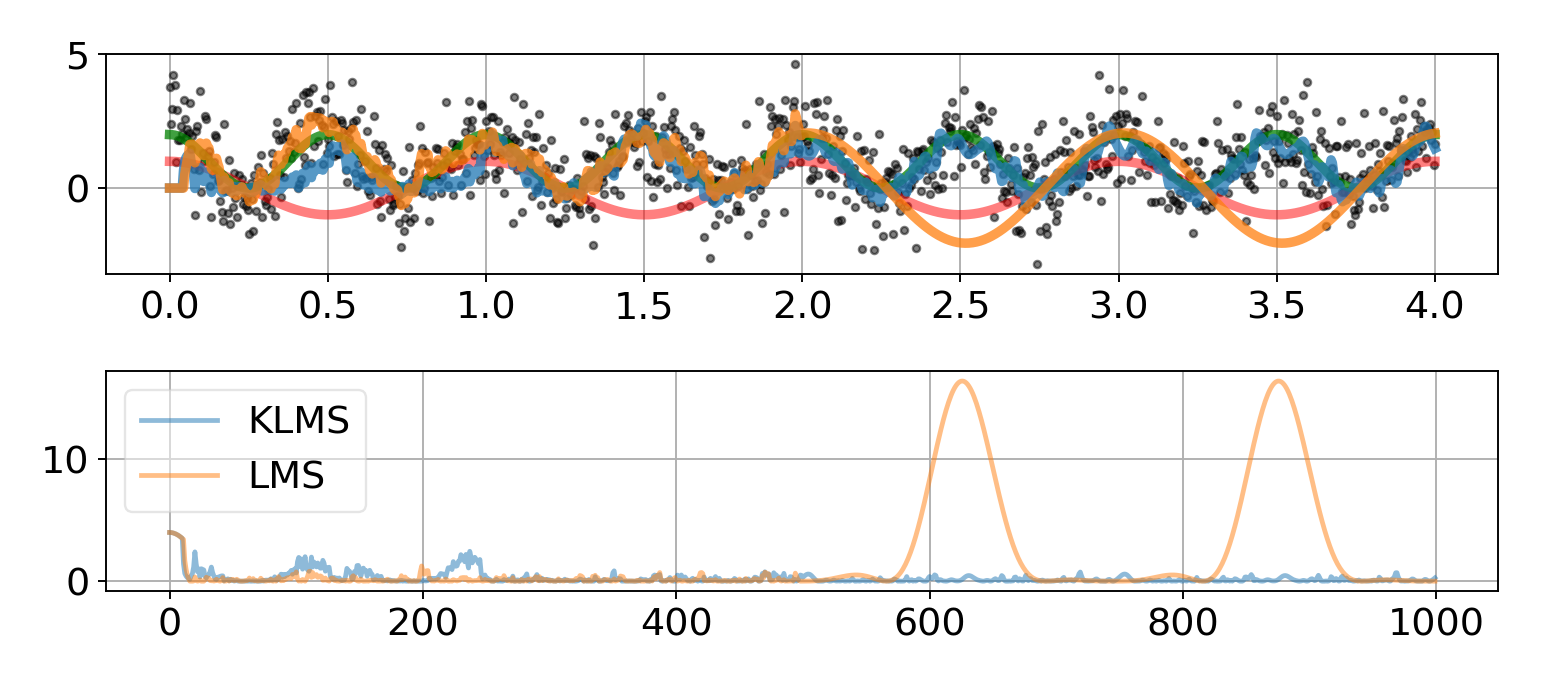

interactive(children=(SelectionSlider(continuous_update=False, description='mu', index=2, layout=Layout(height…

In [10]:
N = 1000;  
t = np.linspace(0, 4, num=N)
u = np.cos(2*np.pi*t)
d_clean = 2*u**2 #+ 0.5*u**3
fig, ax = plt.subplots(2, figsize=(9, 4))

def update(mu, gamma, L, rseed):
    alfa, D = list(), list()
    w = np.zeros(shape=(L+1, ))
    np.random.seed(rseed)
    d = d_clean + 1*np.random.randn(len(t))
    ax[0].cla(); ax[1].cla(); 
    y = np.zeros(shape=(len(u), 2))
    alfa.append(2*mu*d[L+1])
    D.append(u[:L+1])
    # KLMS
    for n in range(L+1, N):
        y[n, 0] = np.sum(np.array(alfa)*np.exp(-gamma*np.sum((u[n-L-1:n] - np.array(D))**2, axis=1)))
        if n < 500:
            alfa.append(2*mu*(d[n+1]-y[n, 0]))
            D.append(u[n-L-1:n])
    # LMS
    for n in range(L+1, N):
        y[n, 1] = np.dot(w, u[n-L-1:n])
        if n < 500:
            norm = np.sum(u[n-L-1:n]**2) + 1e-6
            w += 2*mu*(d[n+1] - y[n, 1])*u[n-L-1:n]/norm
    
    ax[0].plot(t, d, 'k.', alpha=0.5); ax[0].plot(t, u, 'r-', alpha=0.5, lw=4);
    ax[0].plot(t, d_clean, 'g-', alpha=0.75, lw=4);  ax[0].plot(t, y, alpha=0.75, lw=4); 
    ax[1].plot((d_clean - y[:, 0])**2, label='KLMS', alpha=0.5)
    ax[1].plot((d_clean - y[:, 1])**2, label='LMS', alpha=0.5); ax[1].legend()
    
interact(update, mu=SelectionSlider_nice(options=[0.01, 0.05, 0.1, 0.2, 0.5, 1.], value=0.1),
         gamma=SelectionSlider_nice(options=[0.001, 0.01, 0.1, 0.5, 1, 2, 5, 100.], value=1.), 
         L=SelectionSlider_nice(options=[1, 5, 10, 20, 50], value=10),
         rseed=IntSlider_nice());

### Criterio de novedad [(Platt, 1991)](https://dl.acm.org/citation.cfm?id=110091)

- Para evitar que $\mathcal{D}$ crezca demasiado se puede imponer un criterio de *sparsity*
- Por ejemplo, solo incorporar al diccionario una muestra que sea "distinta" de las anteriores y cuyo error de predicción sea grande
    - Si $\min_{k=1,\ldots, n} \|(u_{n+1} - u_{k})\|^2 > \delta_1$
    - y además $e_{n+1} > \delta_2$
    - entonces se incorpora $u_{n+1}$ a $\mathcal{D}$

In [11]:
# la señal enviada original
r, fs = sf.read("data/hola1.ogg")
# El sistema que introduce ecos, por ejemplo una sala
h = np.concatenate(([1.0], np.zeros(10), [0.7], np.zeros(10), [0.5], 
                    np.zeros(10), [0.3], np.zeros(10), [0.1], np.zeros(10), [0.05]))
# la señal enviada con eco
rh = np.convolve(r, h)[:len(r)]
# la señal recibida limpia 
s, fs = sf.read("data/hola2.ogg")
s = np.concatenate((s, np.zeros(shape=(len(r)-len(s)))))
# la señal recibida + señal enviada con eco + ruido blanco
srh = s + 0.3*rh + np.random.randn(len(s))*0.005
Audio(srh, rate=int(fs))

<IPython.core.display.Javascript object>


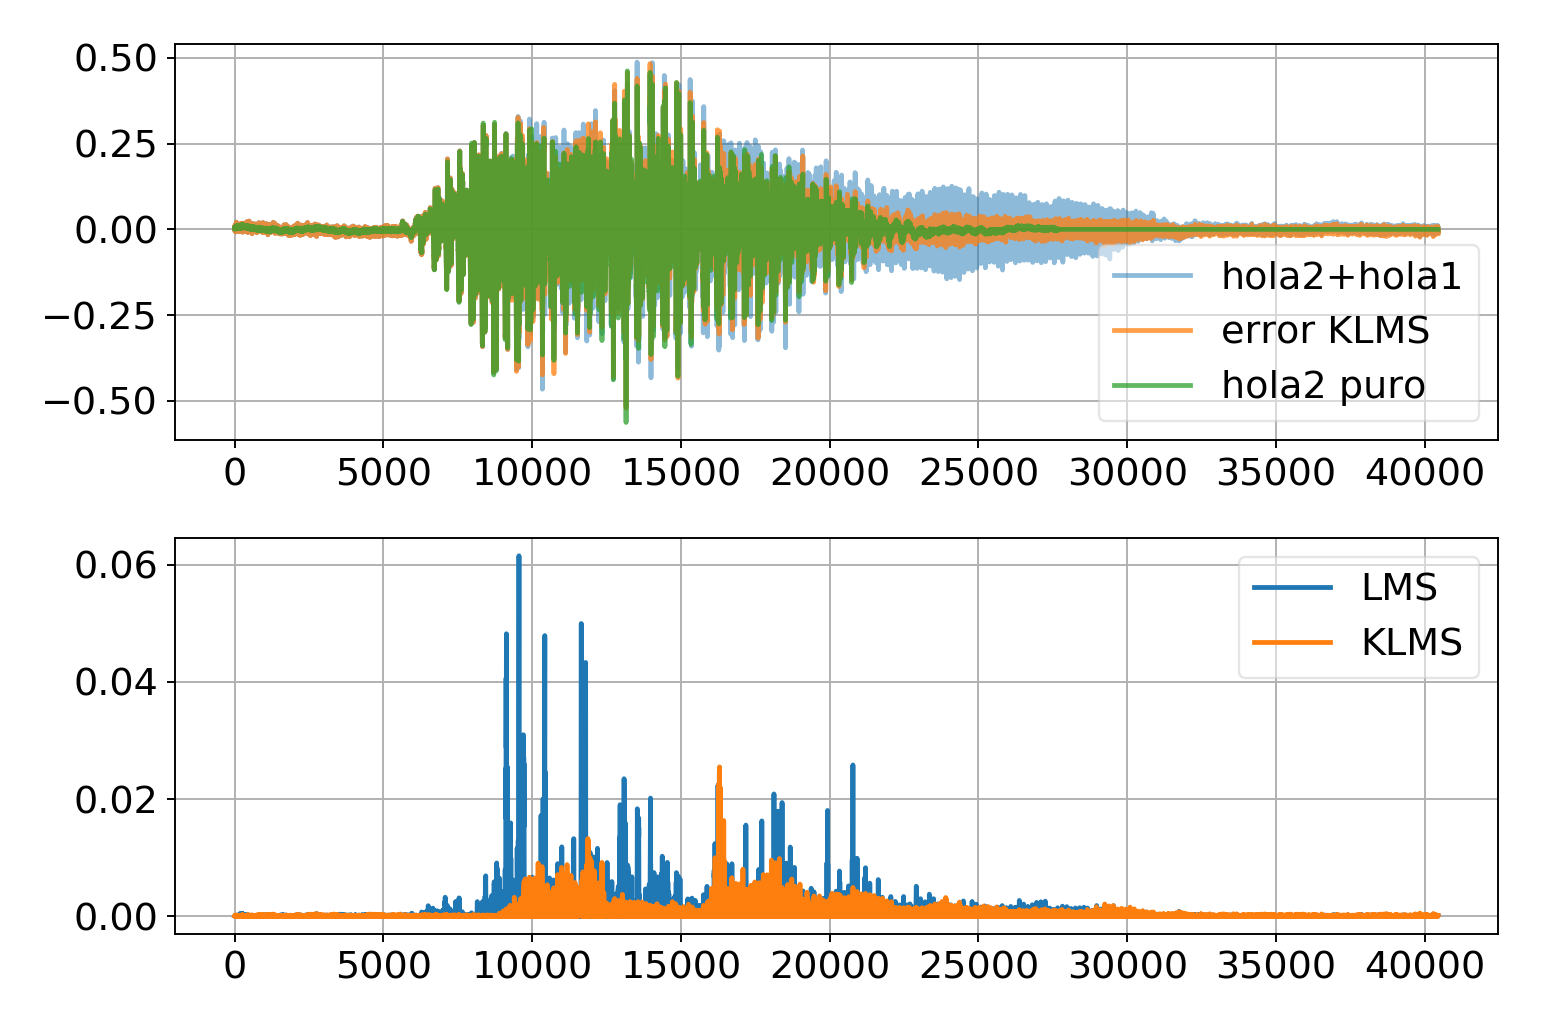

Tamaño del diccionario: 2239
0.0003011816238754762


In [12]:
L, mu, gamma = 10, 0.01, 5.
d1, d2 = 5e-3, 1e-2
fig, ax = plt.subplots(2, figsize=(9, 6))
w = np.zeros(shape=(L, ))
rhhat = np.zeros(shape=(len(srh), 2))
alfa, D = list(), list()
alfa.append(2*mu*srh[L])
D.append(u[0:L])
for n in range(L+1, len(srh)):
    norm = np.sum(r[n-L:n]**2) + 1e-10
    rhhat[n, 0] = np.dot(w, r[n-L:n])
    rhhat[n, 1] = np.sum(np.array(alfa)*np.exp(-gamma*np.sum((r[n-L:n] - np.array(D))**2, axis=1)))
    w += 2*mu*(srh[n] - rhhat[n, 0])*r[n-L:n]/(norm)
    dist = np.sum((r[n-L:n] - np.array(D))**2, axis=1)
    if np.amin(dist) > d1 and np.absolute(srh[n] - rhhat[n, 1]) > d2:
        alfa.append(2*mu*(srh[n]-rhhat[n, 1]))
        D.append(r[n-L:n])
        
print("Tamaño del diccionario: %d" %(len(alfa)))

ax[0].plot(srh, alpha=0.5, label='hola2+hola1');
ax[0].plot(srh - rhhat[:, 1], alpha=0.75, label='error KLMS');
ax[0].plot(s, alpha=0.75, label='hola2 puro');
ax[0].legend()
ax[1].plot((s - srh + rhhat[:, 0])**2, label='LMS')
ax[1].plot((s - srh + rhhat[:, 1])**2, label='KLMS'), ax[1].legend()
print(np.mean((s - srh + rhhat[:, 1])**2))

In [13]:
#LMS
Audio(srh - rhhat[:, 0], rate=int(fs))

In [14]:
# KLMS
Audio(srh - rhhat[:, 1], rate=int(fs))

### Más allá de KLMS

- [KLMS cuantizado](https://www.ncbi.nlm.nih.gov/pubmed/24808453)
- [KLMS con tamaño de kernel adaptivo](https://arxiv.org/abs/1401.5899)


***
# Regresión ridge con kernel (KRR)
***

- El filtro de Wiener es la versión offline del algoritmo LMS
- La solución de Wiener es equivalente a una regresión lineal
- Consideremos que
    - Transformamos los datos usando $\varphi(\cdot)$, una transformacion no lineal
    - Nuestro filtro es lineal en el espacio transformado
$$
y_n = \langle \Omega , \varphi(\textbf{u}_n)  \rangle
$$
- Asumiendo que tenemos $N$ tuplas $(d_n, \varphi(\textbf{u}_n))$
- Escribimos la función de costo del regresor regularizado en forma matricial como
$$
\mathcal{L}(\Omega) = (\textbf{d} - \Phi_u \Omega)^T (\textbf{d} - \Phi_u \Omega) + \lambda \Omega^T \Omega
$$
con $\textbf{d} = (d_1, d_2, \dots, d_N)$, y 
$$
\Phi_u = \begin{pmatrix} \varphi(\textbf{u_1}) \\ \varphi(\textbf{u_2}) \\ \vdots \\ \varphi(\textbf{u_N}) \end{pmatrix} \in \mathbb{R}^{N \times M}
$$
donde $M$ es la dimensión de la transformación no lineal
- Derivando e igualando a cero se tiene la solución de mínimos cuadrados
$$
\begin{align}
\Omega &= (\Phi_u^T \Phi_u + \lambda I_M)^{-1} \Phi_u^T \textbf{d} \nonumber \\
&= \Phi_u^T (\Phi_u \Phi_u^T + \lambda I_N)^{-1} \textbf{d} \nonumber \\
&= \Phi_u^T (K + \lambda I_N)^{-1} \textbf{d} \nonumber \\
&= \Phi_u^T \alpha \nonumber \\
&= \sum_{i=1}^N \varphi(\textbf{u}_i)^T \alpha_i \nonumber 
\end{align}
$$
donde llamamos 
$$
K = \Phi_u \Phi_u^T = 
\begin{pmatrix} 
\kappa(u_1, u_1) &  \kappa(u_1, u_2)&  \ldots& \kappa(u_1, u_N) \\ 
\kappa(u_2, u_1) &  \kappa(u_2, u_2) & \ldots& \kappa(u_2, u_N) \\ 
\vdots &  \vdots & \ddots & \vdots \\
\kappa(u_N, u_1) &  \kappa(u_N, u_2)& \ldots& \kappa(u_N, u_N) 
\end{pmatrix} \in \mathbb{R}^{N\times N}
$$ la matriz Gram
- Para un nuevo valor $x$ la salida del regresor es
$$
\begin{align}
f_\Omega(x) &= \langle \Omega,  \varphi(x) \rangle \nonumber \\
&= \Omega^T  \varphi(x) \nonumber \\
&= \textbf{d}^T (K + \lambda I_N)^{-1}  \Phi_u \varphi(x) \nonumber \\
&= \textbf{d}^T (K + \lambda I_N)^{-1} \begin{pmatrix} \kappa(u_1, x) \\ \kappa(u_2, x) \\ \vdots \\ \kappa(u_N, x)\end{pmatrix}
\end{align}
$$
que no depende de $\varphi(x)$ sólo del kernel!
- Los parámetros del kernel y $\lambda$ pueden seleccionarse con validación cruzada

In [15]:
from sklearn.kernel_ridge import KernelRidge
help(KernelRidge)

Help on class KernelRidge in module sklearn.kernel_ridge:

class KernelRidge(sklearn.base.BaseEstimator, sklearn.base.RegressorMixin)
 |  KernelRidge(alpha=1, kernel='linear', gamma=None, degree=3, coef0=1, kernel_params=None)
 |  
 |  Kernel ridge regression.
 |  
 |  Kernel ridge regression (KRR) combines ridge regression (linear least
 |  squares with l2-norm regularization) with the kernel trick. It thus
 |  learns a linear function in the space induced by the respective kernel and
 |  the data. For non-linear kernels, this corresponds to a non-linear
 |  function in the original space.
 |  
 |  The form of the model learned by KRR is identical to support vector
 |  regression (SVR). However, different loss functions are used: KRR uses
 |  squared error loss while support vector regression uses epsilon-insensitive
 |  loss, both combined with l2 regularization. In contrast to SVR, fitting a
 |  KRR model can be done in closed-form and is typically faster for
 |  medium-sized datase

<IPython.core.display.Javascript object>


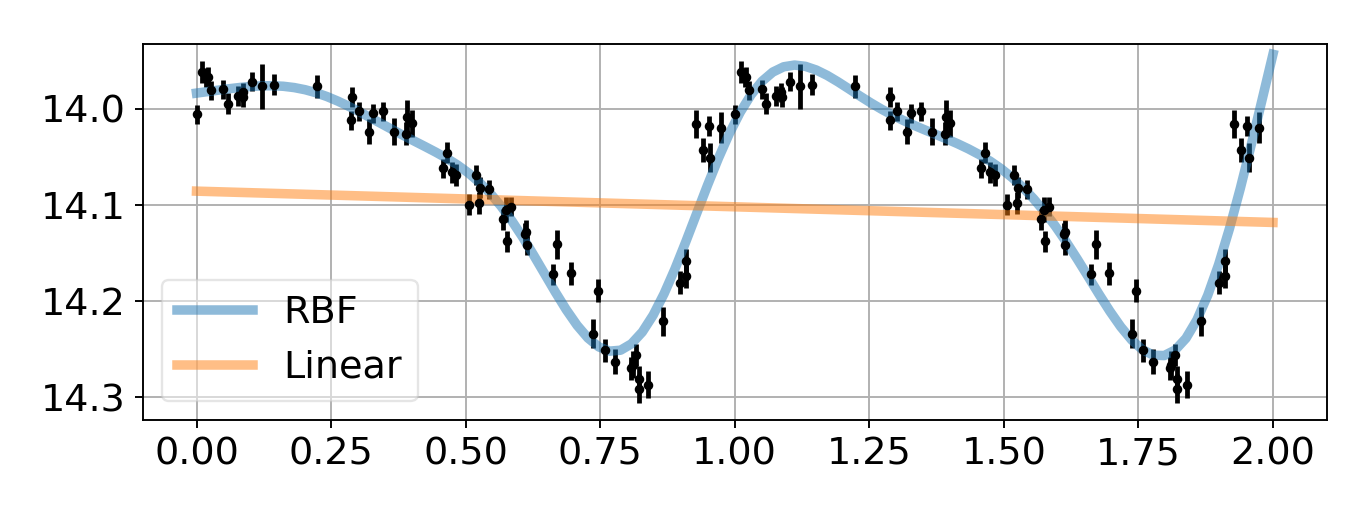

interactive(children=(FloatSlider(value=0.001, continuous_update=False, description='lamb', layout=Layout(heig…

In [17]:
from sklearn.kernel_ridge import KernelRidge
lc_data, period = np.loadtxt("data/rrl.dat"), 0.511941
mjd, mag, err = lc_data[:, :3].T
phi = np.mod(mjd, period)/period
I = np.argsort(phi)
phi, mag, err = np.hstack(([phi[I], phi[I]+1])), np.hstack(([mag[I], mag[I]])), np.hstack(([err[I], err[I]]))
fig, ax = plt.subplots(1, figsize=(8, 3))
ax.errorbar(phi, mag, err, fmt='.', c='k')
ax.invert_yaxis()
phi_reg = np.linspace(0, 2, num=100)
line_rbf = ax.plot(phi_reg, np.mean(mag)+np.zeros_like(phi_reg), lw=4, alpha=0.5, label='RBF')
line_lin = ax.plot(phi_reg, np.mean(mag)+np.zeros_like(phi_reg), lw=4, alpha=0.5, label='Linear')
ax.legend();

def update(lamb, gamma):
    reg = KernelRidge(kernel='rbf', alpha=lamb, gamma=gamma)
    reg.fit(phi.reshape(-1, 1), (mag - np.mean(mag))/np.std(mag))
    mag_regular = reg.predict(phi_reg.reshape(-1, 1))
    line_rbf[0].set_ydata(np.mean(mag)+ np.std(mag)*mag_regular)

    reg = KernelRidge(kernel='linear', alpha=lamb)
    reg.fit(phi.reshape(-1, 1), (mag - np.mean(mag))/np.std(mag))
    mag_regular = reg.predict(phi_reg.reshape(-1, 1))
    line_lin[0].set_ydata(np.mean(mag)+ np.std(mag)*mag_regular)

interact(update, lamb=FloatSlider_nice(min=1e-3, max=1e-1, step=0.01),
         gamma=SelectionSlider_nice(options=[1e-1, .5, 1, 5, 1e+1], value=1.));

### Más allá de KRR

- La versión Bayesiana de KRR se conoce como [proceso Gaussiano](http://www.gaussianprocess.org/)
- El GP entrega incerteza en cada punto del regresor

# Kernels para clasificar: Support Vector Machine

Recordemos, la SVM busca resolver el siguiente problema de optimización con restricciones
$$
\min_w  \frac{1}{2} w^T w  - \sum_i \alpha_i [ y_i (w^T x_i + b) -1]
$$
donde 
- $w$ y $b$ son los parámetros del hiperplano
- $\alpha_i>0$ son los multiplicadores de Lagrange
- Se cuenta con $N$ tuplas $(x_i, y_i)$ para entrenar con $x_i \in \mathbb{R}^M$ y $y_i \in \{-1,1\}$
- Se llama **vectores de soporte** (SV) a las tuplas con $\alpha_i \neq 0$

Derivando en función de $w$ y $b$ se encuentra la forma dual
$$
\max_\alpha \sum_i \alpha_i - \frac{1}{2} \sum_{i, j} \alpha_i \alpha_j y_i y_j \langle x_i, x_j \rangle
$$
sujeto a $\sum_i \alpha_i y_i = 0$

Aparece un producto punto que puede reemplazarse por un kernel!

### C-SVM con kernel

Hay que resolver 
$$
\max_\alpha \sum_i \alpha_i - \frac{1}{2} \sum_{i, j} \alpha_i \alpha_j y_i y_j \kappa(x_i, x_j)
$$
sujeto a $\sum_i \alpha_i y_i = 0$ y $0<\alpha_i< C/N$

Y el hiperplano para una muestra nueva es 
$$
h(x) = \sum_i \alpha_i y_i \kappa(x_i, x) + b
$$

A diferencia de KRR, la SVM es una solución *sparse*, es decir no ocupa todos los ejemplos (solo los SV)

### Parámetros

- $C$ representa un trade-off entre complejidad y ejemplos mal clasificados
    - $C$ pequeño: Hiperplano suave, pocos vectores de soporte, 
    - $C$ grande: Hiperplano complejo, muchos vectores de soporte
    - $C \to \infty$: Caso perfectamente separable
- $\gamma$ controla la influencia de los SV en la clasificación de un punto cualquiera $x$
    - $\gamma$ muy pequeño: Hiperplano muy simple tiende a una linea
    - $\gamma$ pequeño: Vectores lejanos a $x$ pueden influyen en su clase 
    - $\gamma$ grande: Sólo los vectores más cercanos a $x$ influyen en su clase. 
    - $\gamma$ muy grande: Hiperplano muy complejo y sobreajustado
    

In [18]:
from sklearn.svm import SVC
help(SVC)

Help on class SVC in module sklearn.svm.classes:

class SVC(sklearn.svm.base.BaseSVC)
 |  SVC(C=1.0, kernel='rbf', degree=3, gamma='auto_deprecated', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', random_state=None)
 |  
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time complexity
 |  is more than quadratic with the number of samples which makes it hard
 |  to scale to dataset with more than a couple of 10000 samples.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 |  other, see the corresponding section in the narrative documentation:
 |  :ref:`svm_kernels`.
 |  
 |  Read more in the :ref:`User Guide <svm_classification>`.
 |  
 |  Parameters
 |  ----------
 | 

<IPython.core.display.Javascript object>


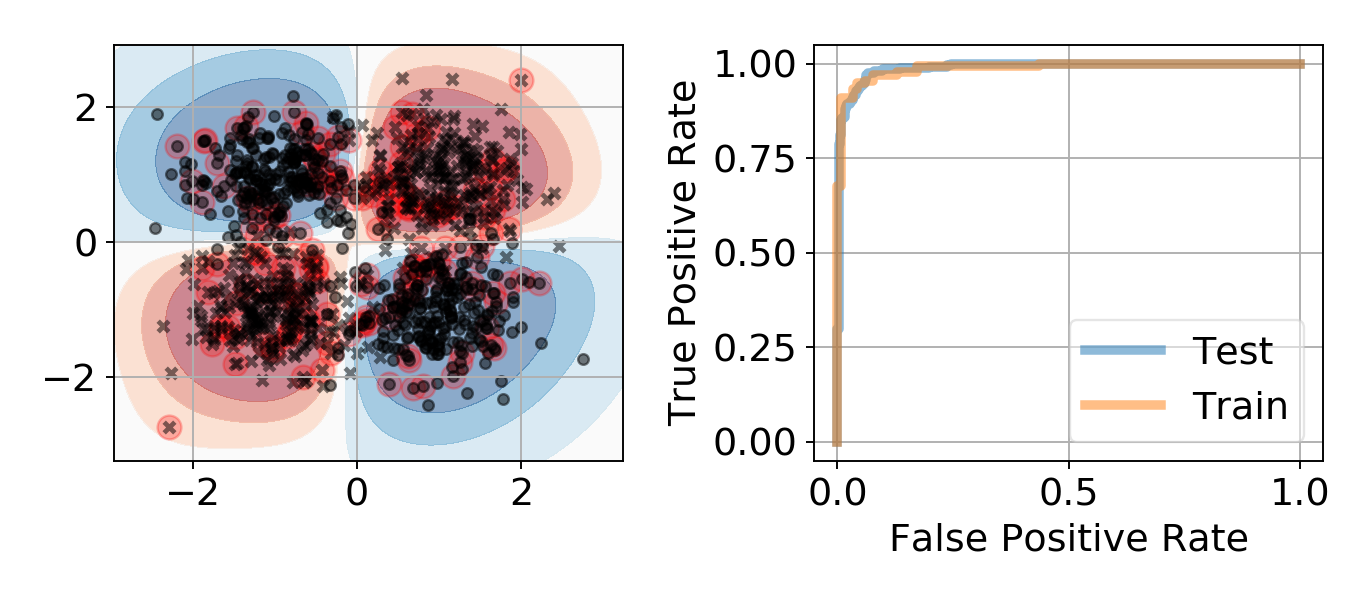

interactive(children=(FloatSlider(value=0.01, continuous_update=False, description='C', layout=Layout(height='…

In [21]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
X, Y = make_blobs(n_samples=1000, centers=[[1, 1], [-1, 1], [1, -1], [-1, -1]], cluster_std=0.5)
Y[Y==2], Y[Y==3] = 1.0, 0.0
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.25, test_size=0.75)
# Create meshgrid for the probability plots
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))

def update(C, gamma):
    ax[0].cla(); ax[1].cla();
    classifier = SVC(C=C, kernel='rbf', gamma=gamma, probability=True)
    classifier.fit(X_train, Y_train)
    Y_pred = classifier.predict_proba(X_test)
    Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    cr = ax[0].contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.RdBu, alpha=0.5)
    ax[0].scatter(X_train[classifier.support_, 0], X_train[classifier.support_, 1], 
               c='r', linewidth=1, alpha=0.25, s=100)
    ax[0].scatter(X[Y==0, 0], X[Y==0, 1], c='k', marker='x', 
               s=20, alpha=0.5, label='class 1')
    ax[0].scatter(X[Y==1, 0], X[Y==1, 1], c='k', marker='o', 
               s=20, alpha=0.5, label='class 2')

    fpr, tpr, th = roc_curve(Y_test, Y_pred[:, 1])
    ax[1].plot(fpr, tpr, linewidth=4, alpha=0.5, label='Test')
    print("Area under the ROC curve (test): %f" %(auc(fpr, tpr)))
    fpr, tpr, th = roc_curve(Y_train, classifier.predict_proba(X_train)[:, 1])
    ax[1].plot(fpr, tpr, linewidth=4, alpha=0.5, label='Train')
    print("Area under the ROC curve (train): %f" %(auc(fpr, tpr)))
    plt.legend(loc=4)
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')

    print("%d SVs for class 1" % (classifier.n_support_[0]))
    print("%d SVs for class 2" % (classifier.n_support_[1]))
    
interact(update, C=FloatSlider_nice(min=1e-2, max=1e-1, value=1e-2, step=0.01),
         gamma=SelectionSlider_nice(options=[1e-2, 1e-1, .5, 1, 5, 1e+1], value=1.));

## Otros métodos lineales kernelizables

- Principal component analysis
- Recursive least squares 